In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
plt.rcParams.update({'font.size': 18})
from matplotlib.colors import LogNorm, ListedColormap
import h5py
import numpy as np

from cora.signal import corr21cm
from cora.util import cosmology
from cora.util import units as u
from cora.signal.lssmodels import bias, sigma_P
from cora.signal.lssmodels import omega_HI

from draco.analysis.powerspec import get_1d_ps


In [2]:
from cora.signal.lssmodels import omega_HI

tb_cora    = corr21cm.Corr21cm()
cora_cosmo = cosmology.Cosmology()

z_eff = 1.0

h_TNG       = 0.6774
omega_m_TNG = 0.3089
omega_l_TNG = 0.6911
omega_b_TNG = 0.0486
ns_TNG     = 0.9667

H0_TNG      = 100 * h_TNG
ombh2_TNG   = omega_b_TNG * (h_TNG**2)  
omch2_TNG   = (omega_m_TNG - omega_b_TNG) * (h_TNG**2) 

print("H0_TNG:", H0_TNG , "ombh2_TNG:", ombh2_TNG, "omch2_TNG:", omch2_TNG)



print(cora_cosmo.omega_m)
print(cora_cosmo.omega_l)


omega_HI_cright     = omega_HI["Crighton2015"](z_eff)*10**3
omega_HI_cora       = tb_cora.omega_HI(z_eff)*10**3

print(omega_HI_cright, omega_HI_cora)




H0_TNG: 67.74 ombh2_TNG: 0.022301118935999998 omch2_TNG: 0.11944405882800001
0.30964
0.69036
0.6062866266041592 0.62


In [ ]:

k_perp_start = 0.08248531501048825
k_perp_end = 0.40298683872971497
k_para_start = -1.5947546202481255
k_para_end = 1.582295599777437


#kpara_start 0.37377061412065443
#kpara_endt 1.582295599777437
#kperp_start 0.08248531501048825
#kperp_end 0.40298683872971497



Lbox300_hinv = 205  # h^-1 Mpc

# Calculate fundamental frequency
k_f = 2 * np.pi / Lbox300_hinv  # ≈ 0.03064968 h/Mpc

# Calculate the number of steps using the fundamental frequency
n_perp_steps = int(np.floor((k_perp_end - k_perp_start) / k_f))
n_para_steps = int(np.floor((k_para_end - k_para_start) / k_f))

# Create arrays with exact fundamental frequency spacing
k_perp_300 = k_perp_start + np.arange(n_perp_steps + 1) * k_f
k_para_300 = k_para_start + np.arange(n_para_steps + 1) * k_f



print(f"Fundamental frequency k_f = {k_f:.8f} h/Mpc")
print(f"Delta k_perp = {k_perp_300[1] - k_perp_300[0]:.8f} h/Mpc")
print(f"Delta k_para = {k_para_300[1] - k_para_300[0]:.8f} h/Mpc")

Fundamental frequency k_f = 0.03064968 h/Mpc
Delta k_perp = 0.03064968 h/Mpc
Delta k_para = 0.03064968 h/Mpc


In [4]:
def T_b_4_TNG(z):
    r"""Mean 21cm brightness temperature at a given redshift.

    Temperature is in K.

     Parameters
    ----------
    z : array_like
        Redshift to calculate at.

    Returns
        -------
    T_b : array_like

    """

    return (
        3.9e-4
        * ((omega_m_TNG + omega_l_TNG * (1 + z) ** -3) / 0.29)
        ** -0.5
        * ((1.0 + z) / 2.5) ** 0.5
        * (omega_HI["Crighton2015"](z) / 1e-3)
    )

print("T_b_4_TNG:", T_b_4_TNG(z_eff)*10**3)
print("T_b cora:", tb_cora.T_b(z_eff)*10**3)

T_b_4_TNG: 0.18114654187096935
T_b cora: 0.18509229560432341


In [5]:
import numpy as np
import camb
from camb import model, initialpower




def get_matter_power_spectrum(redshift):
    """Generate matter power spectrum using CAMB"""
    
    # Get linear spectrum 
    pars_lin = camb.CAMBparams()
    pars_lin.set_cosmology(H0=H0_TNG, ombh2=ombh2_TNG, omch2=omch2_TNG)
    pars_lin.InitPower.set_params(ns=ns_TNG)
    pars_lin.set_matter_power(redshifts=[redshift], kmax=2.0)
    pars_lin.NonLinear = model.NonLinear_none
    results_lin = camb.get_results(pars_lin)
    kh_lin, z_lin, pk_lin = results_lin.get_matter_power_spectrum(minkh=0.01, maxkh=2.0, npoints=600)
    
    # Get non-linear spectrum using Halofit
    pars_halofit = camb.CAMBparams()
    pars_halofit.set_cosmology(H0=H0_TNG, ombh2=ombh2_TNG, omch2=omch2_TNG)
    pars_halofit.InitPower.set_params(ns=ns_TNG)
    pars_halofit.set_matter_power(redshifts=[redshift], kmax=2.0)
    pars_halofit.NonLinear = model.NonLinear_both
    pars_halofit.NonLinearModel.set_params(halofit_version='takahashi')
    results_halofit = camb.get_results(pars_halofit)
    kh_halofit, z_halofit, pk_halofit = results_halofit.get_matter_power_spectrum(minkh=0.01, maxkh=2.0, npoints=600)
    
    # Get non-linear spectrum using HMCode 2016
    pars_hmcode = camb.CAMBparams()
    pars_hmcode.set_cosmology(H0=H0_TNG, ombh2=ombh2_TNG, omch2=omch2_TNG)
    pars_hmcode.InitPower.set_params(ns=ns_TNG)
    pars_hmcode.set_matter_power(redshifts=[redshift], kmax=2.0)
    pars_hmcode.NonLinear = model.NonLinear_both
    pars_hmcode.NonLinearModel.set_params(halofit_version='mead2020')
    results_hmcode = camb.get_results(pars_hmcode)
    kh_hmcode, z_hmcode, pk_hmcode = results_hmcode.get_matter_power_spectrum(minkh=0.01, maxkh=2.0, npoints=600)
    
    return kh_hmcode, pk_lin[0], pk_halofit[0], pk_hmcode[0]





In [6]:
k, pk_lin, pk_halofit, pk_hmcode = get_matter_power_spectrum(1.0)

print(pk_halofit/pk_hmcode)

[0.99764626 0.99762687 0.99760734 0.99758767 0.99756786 0.99754791
 0.99752782 0.99750758 0.99748719 0.99746666 0.99744598 0.99742515
 0.99740418 0.99738305 0.99736178 0.99734036 0.9973188  0.99729708
 0.99727522 0.99725321 0.99723106 0.99720876 0.99718631 0.99716371
 0.99714096 0.99711807 0.99709503 0.99707185 0.99704852 0.99702504
 0.99700141 0.99697764 0.99695372 0.99692966 0.99690546 0.99688112
 0.99685665 0.99683204 0.99680731 0.99678244 0.99675745 0.99673233
 0.9967071  0.99668174 0.99665627 0.99663069 0.996605   0.9965792
 0.99655331 0.99652731 0.99650122 0.99647504 0.99644877 0.99642241
 0.99639598 0.99636947 0.9963429  0.99631626 0.99628959 0.99626287
 0.99623612 0.99620934 0.99618255 0.99615575 0.99612896 0.99610217
 0.9960754  0.99604866 0.99602196 0.9959953  0.99596871 0.99594218
 0.99591573 0.99588936 0.99586309 0.99583693 0.99581089 0.99578497
 0.9957592  0.99573357 0.99570812 0.99568285 0.99565777 0.9956329
 0.99560824 0.99558382 0.99555965 0.99553573 0.99551208 0.995488

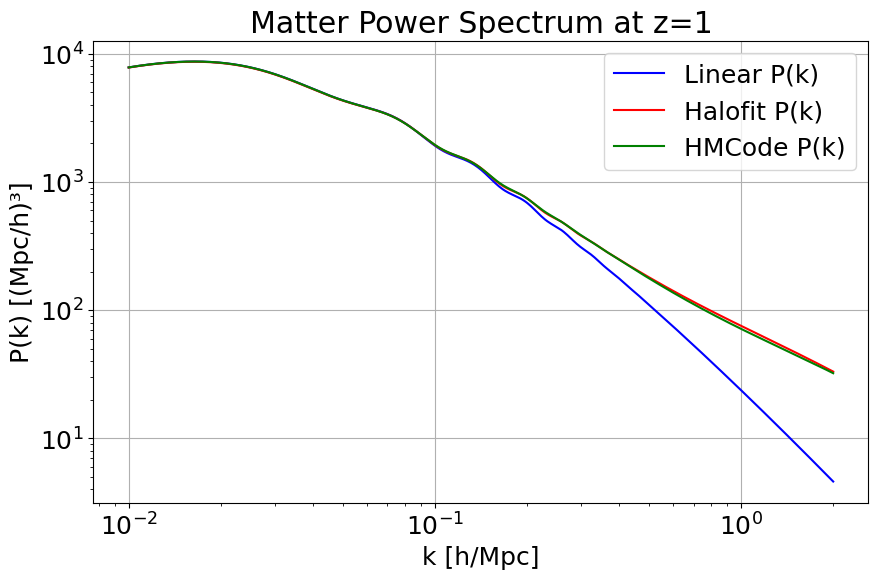

In [7]:
import matplotlib.pyplot as plt


k, pk_lin, pk_halofit, pk_hmcode = get_matter_power_spectrum(1.0)
plt.figure(figsize=(10, 6))
plt.loglog(k, pk_lin, label='Linear P(k)', color='blue')
plt.loglog(k, pk_halofit, label='Halofit P(k)', color='red')
plt.loglog(k, pk_hmcode, label='HMCode P(k)', color='green')
plt.xlabel(r'k [h/Mpc]')
plt.ylabel(r'P(k) [(Mpc/h)³]')
#plt.xlim(k[0],0.2)
plt.legend()
plt.grid(True)
plt.title('Matter Power Spectrum at z=1')
plt.show()

In [8]:
def setup_k_grid():
    """Setup k-space grid """
    k_perp = k_perp_300
    #print(k_perp)
    k_para = k_para_300
    #print(k_perp[10]-k_perp[11])


    
    # Create meshgrid
    kpp, kll = np.meshgrid(k_perp, k_para)
    k = np.sqrt(kpp**2 + kll**2)
    #print(k.max(), k.min())
    mu = np.divide(kll, k, out=np.zeros_like(k), where=k!=0)  # cosine of angle 
    #mu = np.nan_to_num(mu, 0.0)
   
    return k_perp, k_para, kpp, kll, k, mu

In [9]:
omega_HI_fid_mK = omega_HI["Crighton2015"](z_eff)*10**3 # in mK

bias_HI_fid = bias["HI"](z_eff)+1
sigma_P_HI_fid = sigma_P["HI"](z_eff) # in km/s

print(omega_HI_fid_mK,bias_HI_fid, sigma_P_HI_fid)
print((T_b_4_TNG(z_eff))**1)


0.6062866266041592 1.4889999999999999 1.93
0.00018114654187096935


In [10]:


def power_spectrum_expression_NL(k, mu, pk_lin, pk_nonlin, k_input, z_eff, params):
    """
    Generate power spectrum components using CAMB and cora
    """

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0_TNG, ombh2=ombh2_TNG, omch2=omch2_TNG)
    pars.InitPower.set_params(ns=ns_TNG)
    pars.set_matter_power(redshifts=[z_eff], kmax=2.0)


    background = camb.get_background(pars)
    results = camb.get_results(pars)
    
    # Get growth rate f(z_eff)
    sigma8_zeff = results.get_sigma8()
    f_sigma8_zeff = results.get_fsigma8()
    f_z = f_sigma8_zeff/sigma8_zeff
    
    T_b_fid = (3.9e-4 * ((omega_m_TNG + omega_l_TNG * (1 + z_eff) ** -3) / 0.29)** -0.5
            * ((1.0 + z_eff) / 2.5) ** 0.5
            * (( params['alpha_omega']*10**-3)/ 1e-3) * 10**3
        )  # in mK
    
    #print("T_b_fid:", T_b_fid)
    


    # Get T_b from cora
    #tb_cora = corr21cm.Corr21cm()
    #T_b_fid = tb_cora.T_b(z_eff)*10**3  # Convert to mK
    
    # HI bias from cora
    b_HI_fid =  params['alpha_HI']
    sigma_v  = params['alpha_FoG']
    alpha_NL = params['alpha_NL']

    sigma_int = params['alpha_int']   

    P_SN = params['alpha_PSN']  

    # Kaiser term
    kaiser =(b_HI_fid  + f_z*mu**2)**2
    
    # Finger of God damping from cora

    #FoG
    #fog = 1.0 / (1.0 + (k**2 * mu**2 * sigma_v**2)/2.)
    

    #alpha_FoG_HI = params['alpha_FoG']


    # FoG damping with σP,HI(z) = αFoG,HI σfidP,HI(z)
    fog = 1.0 / (1.0 + (k**2 * mu**2 *  sigma_v**2)/2.0)
    fog_int = 1.0 / (1.0 + (k**2 * mu**2 * sigma_int**2)/2.0)
    

    #print(fog- fog_new)



    #print(k_input.shape, k.shape)

    #Interpolate so that pk_lin can be obtained in a 2D grid
    from scipy.interpolate import interp1d

    P_matter_interp_lin = interp1d(k_input, pk_lin, 
                                    bounds_error=False, fill_value='extrapolate')
    P_matter_lin = P_matter_interp_lin(k)


    P_matter_interp_nonlin = interp1d(k_input, pk_nonlin, 
                                    bounds_error=False, fill_value='extrapolate')
    P_matter_nonlin = P_matter_interp_nonlin(k)
    




    ps1 = (P_matter_lin + alpha_NL* (P_matter_nonlin - P_matter_lin) ) * fog**2

    P_HI_1 = T_b_fid**2  * kaiser * ps1

    P_HI_2 = P_SN * fog_int**2  # Add shot noise term

    P_HI = P_HI_1 + P_HI_2



    return P_HI # in mK^2 (Mpc/h)^3





# Get PS theory

In [11]:
k_perp, k_para, kpp, kll, k, mu = setup_k_grid()
k_input, pk_lin, pk_halofit, pk_hmcode = get_matter_power_spectrum(z_eff)

# Base parameters
temp_params = {
    'alpha_omega': omega_HI_fid_mK,
    'alpha_HI': bias_HI_fid,
    'alpha_FoG': sigma_P_HI_fid,
    'alpha_NL': 1.0,     
    'alpha_PSN': 1.0,  # Shot noise term
    'alpha_int': 0.5,  # Finger of God damping
}

pk_nonlinear_model = pk_hmcode
P_theory = power_spectrum_expression_NL(k, mu, pk_lin, pk_nonlinear_model, k_input, z_eff, temp_params)




(104, 11)


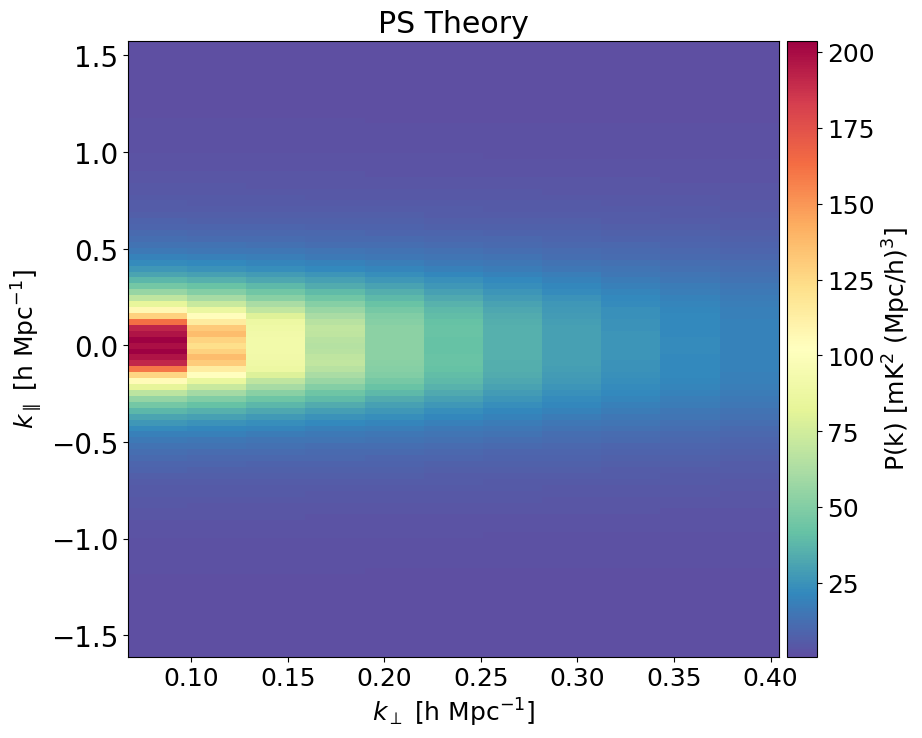

In [12]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(k_perp, k_para, P_theory, cmap='Spectral_r')#, vmin=-50, vmax=50)
print(P_theory.shape)
#plt.xscale('log')
#plt.ylim(0.25302694677898274,k_para.max())

plt.colorbar(label='P(k) [mK$^2$ (Mpc/h)$^3$]', pad=0.01)
plt.xlabel(r'$k_\perp$ [h Mpc$^{-1}$]')
plt.ylabel(r'$k_\parallel$ [h Mpc$^{-1}$]')

plt.yticks(fontsize=20)
plt.title(f'PS Theory')
#plt.savefig(f'non-linear/Total_P-S.png')
plt.show()

# Create a signal mask for TNG binning

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


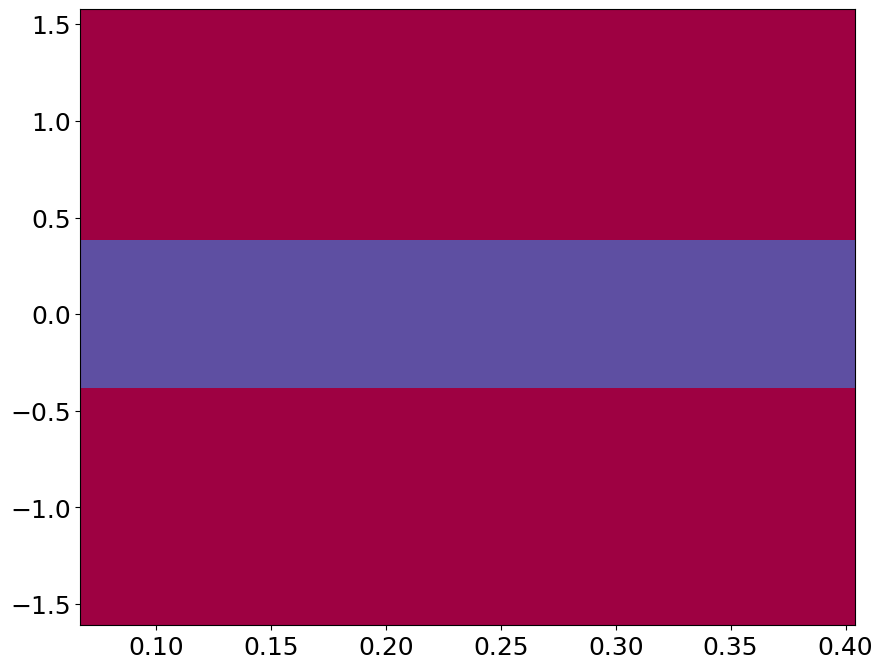

In [13]:
# Define the range for masking
lower_bound = -0.37377061412065443
upper_bound = 0.37377061412065443

mask_full = ~((kll >= lower_bound) & (kll <= upper_bound))
print(mask_full)

plt.figure(figsize=(10, 8))
plt.pcolormesh(k_perp, k_para, mask_full, cmap='Spectral_r')#, vmin=-50, vmax=50)

In [14]:
k_perp, k_para, kpp, kll, k, mu = setup_k_grid()

# Calculate the k range
k_min = k[k > 0].min()  # Minimum non-zero k value
k_max = k.max()         # Maximum k value

#  Use TNG100 observed bin width
bin_width_TNG100 = 0.03064832894463277  # h/Mpc
nbins_TNG100 = int(np.ceil((k_max - k_min) / bin_width_TNG100))


print(f"Using TNG100 bin width:")
print(f"   - Bin width: {bin_width_TNG100:.6f} h/Mpc")
print(f"   - Required bins: {nbins_TNG100}")



Using TNG100 bin width:
   - Bin width: 0.030648 h/Mpc
   - Required bins: 51


In [15]:

nbins = 50
k3d_msk, signal_1D_msk, _, _ = get_1d_ps(
    P_theory*10**-6,  
    k_perp,          
    k_para,         
    weight_cube = np.ones_like(P_theory),
    signal_window = mask_full,
    Nbins_3D=nbins+1,   
    logbins_3D=False )    
print(k3d_msk)

[0.41489549 0.44326813 0.46936894 0.4945166  0.51791144 0.53925714
 0.56480865 0.59175757 0.61777668 0.64149308 0.66473887 0.68913414
 0.71642322 0.74238051 0.76490485 0.78742948 0.81172977 0.83788917
 0.86380913 0.88930066 0.91227967 0.93619087 0.96176937 0.98757216
 1.01192479 1.03595643 1.05901959 1.08368384 1.11040496 1.13621951
 1.16159089 1.18309793 1.20713114 1.23326876 1.25930306 1.28476248
 1.30760695 1.33118879 1.35674401 1.3824152  1.40768241 1.43060077
 1.45369506 1.48088076 1.50711135 1.53136607 1.55431796 1.57774642
 1.60369189 1.62540475]


In [16]:
file_TNG300_2d = "2025-05-06/pk2d_M_HI_rsd_grid_tng300-1_fg09_snap_050_ngrid1024_rsdaxis2_CIC.dat"

In [17]:
def load_pk_TNG(filename):
    """Load TNG power spectrum data"""
    data = np.loadtxt(filename)
    k_TNG = data[:, 0]
    P_0  = data[:, 1]
    P_2  = data[:, 2]
    P_4  = data[:, 3]
    N_modes = data[:, 4]
    return k_TNG, P_0, P_2, P_4, N_modes

filename_50 = "2025-05-06/pkmult_M_HI_rsd_grid_tng50-1_fg09_snap_050_ngrid1024_rsdaxis2_CIC.dat"
filename_100 = "2025-05-06/pkmult_M_HI_rsd_grid_tng100-1_fg09_snap_050_ngrid1024_rsdaxis2_CIC.dat"
filename_300 = "2025-05-06/pkmult_M_HI_rsd_grid_tng300-1_fg09_snap_050_ngrid1024_rsdaxis2_CIC.dat"

k_TNG50, P_0_50, P_2_50, P_4_50, N_modes_50 = load_pk_TNG(filename_50)
k_TNG100, P_0_100, P_2_100, P_4_100, N_modes_100 = load_pk_TNG(filename_100)
k_TNG300, P_0_300, P_2_300, P_4_300, N_modes_300 = load_pk_TNG(filename_300)

tb_cora = corr21cm.Corr21cm()

def convert_to_temp(k_val, P_HI, z_eff=1.0, h=0.6774):
    """Convert to brightness temperature units"""

    #T_b_fid = tb_cora.T_b(z_eff)  # in to K

    k_new = k_val
    pk_mpc3 = P_HI  
    P_new = pk_mpc3 * T_b_4_TNG(z_eff)**2 

    return k_new, P_new


k_new_50, P_new_50 = convert_to_temp(k_TNG50, P_0_50)
k_new_100, P_new_100 = convert_to_temp(k_TNG100, P_0_100)
k_new_300, P_new_300 = convert_to_temp(k_TNG300, P_0_300)


print(k_new_300[1]-k_new_300[0])
print(k_new_300[11]-k_new_300[10])
k_ratios = k_new_300[1:] / k_new_300[:-1]
k_diffs = k_new_300[1:] - k_new_300[:-1]
diff_std = np.std(k_diffs)
diff_mean = np.mean(k_diffs)
print("Mean difference:", diff_mean)
print("diff_mean:", diff_std)



0.030143809500000007
0.030791610000000025
Mean difference: 0.03064832894463277
diff_mean: 0.0006720553437656134


# Load rebinned TNG300 data

In [18]:
TNG_k_rebinned, TNG_pk_rebinned, TNG_frac_err_rebinned, TNG_var_rebinned = np.loadtxt('../TNG_spectra_V2/TNG_rebinned/TNG_rebinned_data.txt', unpack=True)
TNG_std_rebinned = np.sqrt(TNG_var_rebinned)

In [19]:


from scipy import interpolate
def Interpolate_theory(k1, P1, k2, P2, N1):
    """
    Interpolate theory PS1D to mach with k values of TNG
    Parameters:
    -----------
    k1 : array
        Wavenumber array for TNG power spectrum
    P1 : array
        Power spectrum values for TNG dataset
    k2 : array
        Wavenumber array for theory power spectrum
    P2 : array
        Power spectrum values for theory dataset

        
    Returns:
    --------
    
        (k_overlap, P1_overlap, P2_interp) 
    """
    # Find the overlapping k range
    k_min = max(np.min(k1), np.min(k2))
    k_max = min(np.max(k1), np.max(k2))
    
    #print(f"Overlapping k range: {k_min:.6f} to {k_max:.6f}")
    #print(f"k1 range: {np.min(k1):.6f} to {np.max(k1):.6f}")
    #print(f"k2 range: {np.min(k2):.6f} to {np.max(k2):.6f}")
    # Create mask for overlapping range
    mask1 = (k1 >= k_min) & (k1 <= k_max)
    mask2 = (k2 >= k_min) & (k2 <= k_max)
    
    # Get overlapping data
    k1_overlap = k1[mask1]
    P1_overlap = P1[mask1]
    N1_overlap = N1[mask1] 
    
    k2_overlap = k2[mask2]
    P2_overlap = P2[mask2]

    #print(f"Number of k1 points in range: {len(k1_overlap)}")
    #print(f"Number of k2 points in range: {len(k2_overlap)}")

    # Create interpolation function for the second dataset
    # to evaluate it at the same k points as the first dataset
    interp_func = interpolate.interp1d(k2_overlap, P2_overlap, 
                                      kind='linear', bounds_error=False)
    
    # Evaluate the second power spectrum at the k points of the first
    P2_interp = interp_func(k1_overlap)


    return k1_overlap, P1_overlap , N1_overlap,  P2_overlap, P2_interp

k_overlap, P1_overlap, N1_overlap,  P2_overlap, P2_interp = Interpolate_theory(k_new_300, P_new_300, k3d_msk, signal_1D_msk, N_modes_300)
print(k_overlap.shape)

(39,)


In [20]:
print("k_3d_msk:", k3d_msk)
print("TNG_k_rebinned:", TNG_k_rebinned)

k_3d_msk: [0.41489549 0.44326813 0.46936894 0.4945166  0.51791144 0.53925714
 0.56480865 0.59175757 0.61777668 0.64149308 0.66473887 0.68913414
 0.71642322 0.74238051 0.76490485 0.78742948 0.81172977 0.83788917
 0.86380913 0.88930066 0.91227967 0.93619087 0.96176937 0.98757216
 1.01192479 1.03595643 1.05901959 1.08368384 1.11040496 1.13621951
 1.16159089 1.18309793 1.20713114 1.23326876 1.25930306 1.28476248
 1.30760695 1.33118879 1.35674401 1.3824152  1.40768241 1.43060077
 1.45369506 1.48088076 1.50711135 1.53136607 1.55431796 1.57774642
 1.60369189 1.62540475]
TNG_k_rebinned: [0.44184675 0.5307775  0.64532185 0.79443816 0.97757106 1.20265865
 1.4707882 ]


In [21]:


from scipy import interpolate
def Interpolate_theory_rebin(k1, P1, k2, P2):
    """
    Interpolate theory PS1D to mach with k values of TNG
    Parameters:
    -----------
    k1 : array
        Wavenumber array for TNG power spectrum
    P1 : array
        Power spectrum values for TNG dataset
    k2 : array
        Wavenumber array for theory power spectrum
    P2 : array
        Power spectrum values for theory dataset

        
    Returns:
    --------
    
        (k_overlap, P1_overlap, P2_interp) 
    """
    # Find the overlapping k range
    k_min = max(np.min(k1), np.min(k2))
    k_max = min(np.max(k1), np.max(k2))
    
    #print(f"Overlapping k range: {k_min:.6f} to {k_max:.6f}")
    #print(f"k1 range: {np.min(k1):.6f} to {np.max(k1):.6f}")
    #print(f"k2 range: {np.min(k2):.6f} to {np.max(k2):.6f}")
    # Create mask for overlapping range
    mask1 = (k1 >= k_min) & (k1 <= k_max)
    mask2 = (k2 >= k_min) & (k2 <= k_max)
    
    # Get overlapping data
    k1_overlap = k1[mask1]
    P1_overlap = P1[mask1]
    
    k2_overlap = k2[mask2]
    P2_overlap = P2[mask2]

    #print(f"Number of k1 points in range: {len(k1_overlap)}")
    #print(f"Number of k2 points in range: {len(k2_overlap)}")

    # Create interpolation function for the second dataset
    # to evaluate it at the same k points as the first dataset
    interp_func = interpolate.interp1d(k2_overlap, P2_overlap, 
                                      kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # Evaluate the second power spectrum at the k points of the first
    P2_interp = interp_func(k1_overlap)


    return k1_overlap, P1_overlap ,   P2_overlap, P2_interp

k_overlap_rebin, P1_overlap_rebin,  P2_overlap_rebin, P2_interp_rebin = Interpolate_theory_rebin(TNG_k_rebinned, TNG_pk_rebinned, k3d_msk, signal_1D_msk)
print(k_overlap_rebin)
print(P1_overlap_rebin.shape)
print(P2_interp_rebin)


[0.44184675 0.5307775  0.64532185 0.79443816 0.97757106 1.20265865
 1.4707882 ]
(7,)
[2.14447704e-05 1.36597219e-05 8.32587737e-06 4.70476232e-06
 2.62168652e-06 1.53111172e-06 9.66988416e-07]


In [22]:
overlaped_modes = np.where((k_new_300 > 0.096196) & (k_new_300 < 1.620908))
print(N_modes_300[overlaped_modes])
print(N1_overlap)
print(np.sqrt(P_0_300[overlaped_modes]/N_modes_300[overlaped_modes]))

[   79.   117.   205.   235.   369.   433.   585.   679.   813.   985.
  1183.  1269.  1537.  1653.  1963.  2121.  2413.  2635.  2877.  3169.
  3507.  3685.  4165.  4377.  4855.  4929.  5581.  5679.  6385.  6553.
  7125.  7447.  7929.  8353.  8775.  9313.  9841. 10191. 10897. 11301.
 12025. 12423. 13021. 13405. 14247. 14713. 15489. 15913. 16879. 17193.]
[ 1269.  1537.  1653.  1963.  2121.  2413.  2635.  2877.  3169.  3507.
  3685.  4165.  4377.  4855.  4929.  5581.  5679.  6385.  6553.  7125.
  7447.  7929.  8353.  8775.  9313.  9841. 10191. 10897. 11301. 12025.
 12423. 13021. 13405. 14247. 14713. 15489. 15913. 16879. 17193.]
[6.72229316 5.42471023 3.20440439 2.87931512 1.91391648 1.57916531
 1.24772665 1.03132619 0.86930905 0.73596287 0.61461058 0.55606366
 0.46600838 0.4222274  0.35927336 0.3266942  0.29465833 0.26436959
 0.24633091 0.22019952 0.19876746 0.18852682 0.17004028 0.15787185
 0.14584233 0.13764129 0.12619091 0.12077722 0.11147509 0.10582188
 0.09837599 0.09350484 0.088110

TNG300 error: [3.61443099e-07 2.79373027e-07 2.37842443e-07 1.87659378e-07
 1.61292172e-07 1.39951066e-07 1.17726278e-07 1.06799161e-07
 8.95682251e-08 7.67747772e-08 7.07986746e-08 6.12309814e-08
 5.41075382e-08 4.86319718e-08 4.36452491e-08 3.90366229e-08
 3.60716568e-08 3.25833858e-08 2.97461768e-08 2.68059228e-08
 2.47581933e-08 2.26844097e-08 2.09953076e-08 1.92798212e-08
 1.82408460e-08 1.66855892e-08 1.55630103e-08 1.42676377e-08
 1.38493618e-08 1.26110055e-08 1.16791447e-08 1.11045461e-08
 1.04801211e-08 9.88351103e-09 9.47654349e-09 8.80567079e-09
 8.48459272e-09 7.97551175e-09 7.50730719e-09]


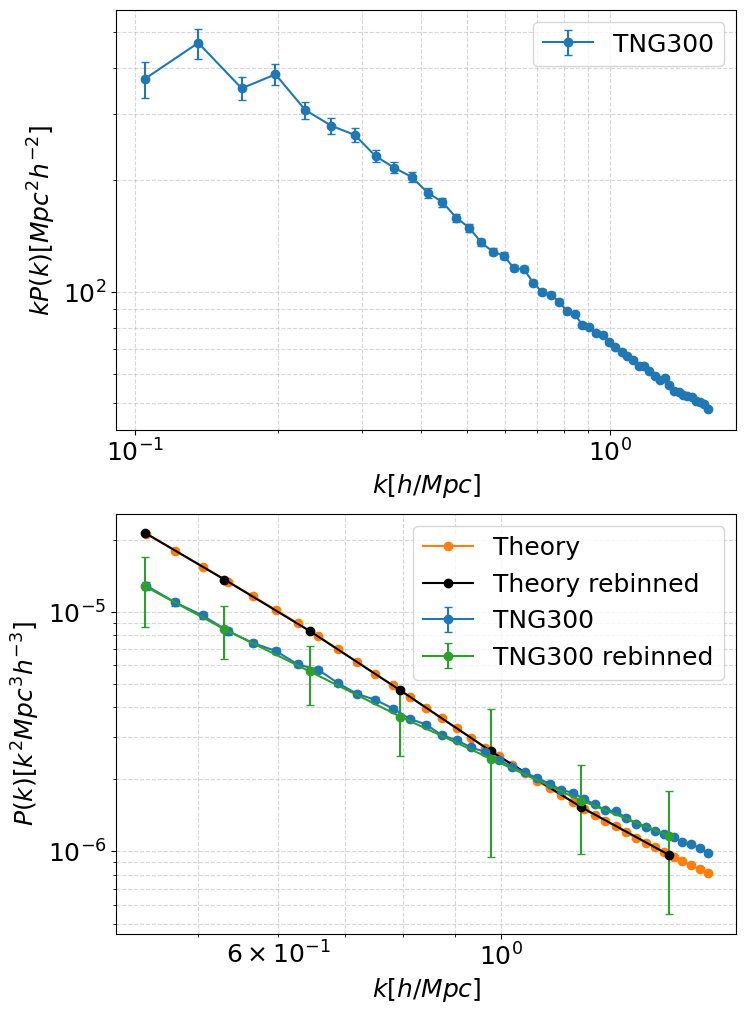

In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,12))

kP_data = P_0_300[overlaped_modes] * k_TNG300[overlaped_modes]
P_error = P_0_300[overlaped_modes] / np.sqrt(N_modes_300[overlaped_modes])
kP_error = P_error * k_TNG300[overlaped_modes]  # Scale error by k

error_scale_factor = 5.0
P1_error_base = P1_overlap * np.sqrt(2.0) / np.sqrt(N1_overlap)
P1_error_scaled_const = P1_error_base * error_scale_factor



ax1.errorbar(k_TNG300[overlaped_modes], kP_data, yerr=kP_error, 
             fmt='o-', label='TNG300', capsize=3)

ax1.set_xlabel('$k [h/Mpc]$')
ax1.set_ylabel('$k P(k) [Mpc^2 h^{-2}]$')
ax1.legend()
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(True, which="both", ls="--", alpha=0.5)

print("TNG300 error:", P1_overlap / np.sqrt(N1_overlap))

ax2.errorbar(k_overlap, P1_overlap, yerr=P1_error_base,fmt='o-', label=f'TNG300   ', capsize=3)
#ax2.plot(k_overlap, P1_overlap, 'o-', label='TNG300')
ax2.plot(k_overlap, P2_interp, 'o-', label='Theory')
ax2.errorbar(k_overlap_rebin, P1_overlap_rebin, yerr=TNG_std_rebinned, fmt='o-', label='TNG300 rebinned', capsize=3)
ax2.plot(k_overlap_rebin, P2_interp_rebin, 'o-', label='Theory rebinned', color='black')

#ax1.plot(k_overlap, P1_overlap/P2_interp, 'o-', label='Ratio')
#ax2.plot(k3d_msk,signal_1D_msk , 'o-', label='true (fiducial params)')
ax2.set_xlabel('$k [h/Mpc]$')
ax2.set_ylabel('$P(k) [k^2 Mpc^3 h^{-3}]$')
ax2.grid(True, which="both", ls="--", alpha=0.5)
ax2.legend()
ax2.set_xscale('log')
ax2.set_yscale('log')
#plt.savefig("plots_may15/TNG300_vs_theory_sigma_kdep.png", bbox_inches='tight')
plt.show()
plt.close()

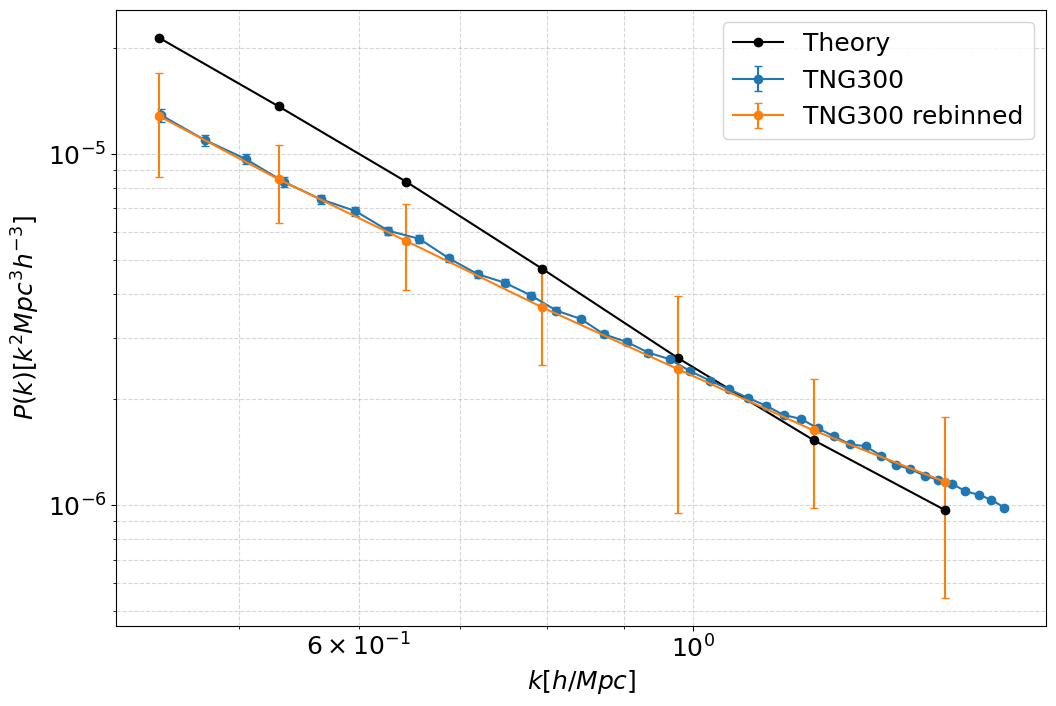

In [41]:
fig, (ax2) = plt.subplots(1, 1, figsize=(12,8))



error_scale_factor = 5.0
P1_error_base = P1_overlap * np.sqrt(2.0) / np.sqrt(N1_overlap)
P1_error_scaled_const = P1_error_base * error_scale_factor

ax2.errorbar(k_overlap, P1_overlap, yerr=P1_error_base,fmt='o-', label=f'TNG300   ', capsize=3)
#ax2.plot(k_overlap, P1_overlap, 'o-', label='TNG300')
#ax2.plot(k_overlap, P2_interp, 'o-', label='Theory')
ax2.errorbar(k_overlap_rebin, P1_overlap_rebin, yerr=TNG_std_rebinned, fmt='o-', label='TNG300 rebinned', capsize=3)
ax2.plot(k_overlap_rebin, P2_interp_rebin, 'o-', label='Theory ', color='black')

#ax1.plot(k_overlap, P1_overlap/P2_interp, 'o-', label='Ratio')
#ax2.plot(k3d_msk,signal_1D_msk , 'o-', label='true (fiducial params)')
ax2.set_xlabel('$k [h/Mpc]$')
ax2.set_ylabel('$P(k) [k^2 Mpc^3 h^{-3}]$')
ax2.grid(True, which="both", ls="--", alpha=0.5)
ax2.legend()
ax2.set_xscale('log')
ax2.set_yscale('log')
plt.savefig("plots_may19/TNG300_vs_theory_SN_FoG_rebin.png", bbox_inches='tight')
plt.show()
plt.close()

# Run MCMC

In [24]:
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

In [ ]:
#P1_error = P1_overlap * np.sqrt(2.0) / np.sqrt(N1_overlap)

#
#error_scale_factor = 5.0
#P1_error_base = P1_overlap * np.sqrt(2.0) / np.sqrt(N1_overlap)
#P1_error_scaled_const = P1_error_base * error_scale_factor

#P1_error_scaled, scale_factors = calculate_k_dependent_errors(P1_overlap, N1_overlap, k_overlap)
#print("P1_error_scaled:", P1_error_scaled)
#print("P1_error_scaled const:", P1_error_scaled_const)

def chi_square(params_array, TNG_k_rebinned, TNG_pk_rebinned, pk_lin, pk_nonlinear_model, k_input, z_eff):
    """Calculate chi-square between model and data"""
    params = {
        'alpha_omega': params_array[0],
        'alpha_HI': params_array[1],
        'alpha_FoG': params_array[2],
        'alpha_NL': params_array[3],
        'alpha_PSN': params_array[4],
        'alpha_int': params_array[5]
    }
    
    # Generate model power spectrum
    P_model = power_spectrum_expression_NL(k, mu, pk_lin, pk_nonlinear_model, k_input, z_eff, params)
    #print("P_mpdel", P_model)
    nbins = 50
    k3d_model, signal_1D_model, _, _ = get_1d_ps(
        P_model*10**-6,  
        k_perp,          
        k_para,         
        weight_cube = np.ones_like(P_model),
        signal_window = mask_full,
        Nbins_3D=nbins+1,   
        logbins_3D=False ) 
    
    #print("signal_1d_model", signal_1D_model)
    # Interpolate to match TNG k-values
    k_overlap_model,  _, _, P_model_interp_rebin = Interpolate_theory_rebin(TNG_k_rebinned, TNG_pk_rebinned, k3d_model, signal_1D_model)
    

    
    #print(f"Model P(k) : {P_model_interp}")
    #print(f"Data P(k) shape: {P1_overlap.shape}")
    #print(f"Model k shape: {k_overlap_model.shape}")
    #print(f"Data k shape: {k_new_300.shape}")
    # Calculate chi-square
    chi2 = np.sum(((P1_overlap_rebin - P_model_interp_rebin) / TNG_std_rebinned )**2)
    
    #print(f"Chi2: {chi2:.2f} with params: {params}")
    return chi2

# Define log-probability function for MCMC
def log_probability(params_array, TNG_k_rebinned, TNG_pk_rebinned, pk_lin, pk_nonlinear_model, k_input, z_eff):
    # First check if parameters are within bounds
    if (0.0 <= params_array[0] <= 10.0 and 
        0.0 <= params_array[1] <= 10.0 and 
        0.0 <= params_array[2] <= 10.0 and 
        0.0 <= params_array[3] <= 10.0 and
        0.0 <= params_array[4] <= 10.0 and
        0.0 <= params_array[5] <= 10.0):
        
        # Calculate chi-square
        chi2 = chi_square(params_array, TNG_k_rebinned, TNG_pk_rebinned, pk_lin, pk_nonlinear_model, k_input, z_eff)
        
        # Convert to log-likelihood 
        log_likelihood = -0.5 * chi2
        

        
        return log_likelihood 
    else:
        return -np.inf

In [26]:
from multiprocessing import Pool
import multiprocessing
ncores = multiprocessing.cpu_count() - 1  
print(f"Using {ncores} CPU cores")


Using 13 CPU cores


In [ ]:
# get best-fit parameters from differential evolution
best_params = {
    'alpha_omega': omega_HI_fid_mK,
    'alpha_HI': bias_HI_fid,
    'alpha_FoG': sigma_P_HI_fid,
    'alpha_NL': 1.0,
     'alpha_PSN': 1.0,  # Shot noise term
    'alpha_int': 0.5,  # Finger of God damping
}

initial_params = np.array([
    best_params['alpha_omega'],
    best_params['alpha_HI'],
    best_params['alpha_FoG'],
    best_params['alpha_NL'],
    best_params['alpha_PSN'],
    best_params['alpha_int']
])

# Set up MCMC
ndim = 6  # Number of parameters
nwalkers = 20  # Number of chains

pos = initial_params + 1e-1 * np.random.randn(nwalkers, ndim)

# Initialize the sampler
sampler = emcee.EnsembleSampler(
    nwalkers, 
    ndim, 
    log_probability,
    args=(TNG_k_rebinned, TNG_pk_rebinned, pk_lin, pk_nonlinear_model, k_input, z_eff)
)



# Run burn-in phase
print("Running burn-in...")
state = sampler.run_mcmc(pos, 100, progress=True)
sampler.reset()

# Run production phase
print("Running production...")
sampler.run_mcmc(state, 5000, progress=True)

Running burn-in...


You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee


Running production...


State([[0.06475966 4.43409186 1.54157084 4.28285609 4.76331121 1.48584743]
 [0.17323969 7.72323403 4.3880794  3.32666816 1.17365777 0.51520954]
 [0.37315124 9.31155223 6.38618709 1.43587039 2.32165453 0.53858024]
 [0.09317654 7.06265574 1.55827184 3.68483667 5.25389749 2.2351633 ]
 [1.49840083 1.45427797 8.72414489 5.24722789 4.88950377 1.13748535]
 [0.46180765 3.3287278  8.31571288 8.6846646  4.75848719 1.37180207]
 [0.09607862 7.35850593 3.11300231 6.12393478 6.76201528 2.18187453]
 [1.13126246 0.19335811 9.2215706  5.86704963 9.73269864 1.25118337]
 [2.01995633 0.37056032 5.25649981 1.79166842 3.70152171 0.92631225]
 [0.44504673 6.25877385 7.05502902 0.9832989  7.8568829  1.56948601]
 [0.51542388 2.10020468 6.99578002 7.73850393 8.88029882 1.96889138]
 [2.66331448 1.88735806 9.80369231 1.12462823 5.92048363 1.26583054]
 [0.13244956 6.27290404 5.24276088 1.74755256 9.06987755 1.42016674]
 [1.04143677 2.39132301 6.35451807 0.79977803 7.54238954 1.24128285]
 [0.29689731 8.29683145 7.22

# Save the samples 

In [28]:
import h5py

param_names = ['alpha_omega', 'alpha_HI', 'alpha_FoG', 'alpha_NL', 'alpha_PSN', 'alpha_int']

with h5py.File("emcee_chains/mcmc_results_5k_hmcode_sigma_normal_SN_fog_rebin.h5", "w") as f:
    f.create_dataset("chain", data=sampler.get_chain())
    f.create_dataset("log_prob", data=sampler.get_log_prob())
    f.attrs["acceptance_fraction"] = sampler.acceptance_fraction
    param_group = f.create_group("parameters")
    for i, name in enumerate(param_names):
        param_group.attrs[f"param_{i}"] = name
print("MCMC results saved!")




MCMC results saved!


# Load MCMC results

log_prob shape: (5000, 20)
log_prob: [[-0.78491298 -2.56823718 -2.61812288 ... -6.08643611 -2.88232777
  -1.01646134]
 [-0.88840211 -2.56823718 -2.61812288 ... -6.08643611 -2.88232777
  -0.15590517]
 [-1.63238268 -2.56823718 -8.26457706 ... -7.62207917 -0.07784692
  -0.13582941]
 ...
 [-3.21830659 -2.78898127 -1.30758505 ... -1.43309814 -0.27137133
  -0.70417144]
 [-3.93711689 -2.78898127 -1.30758505 ... -0.96394469 -0.27137133
  -0.70417144]
 [-3.93711689 -2.78898127 -1.30758505 ... -1.6209078  -0.27137133
  -0.70417144]]
(98000, 6)
param_labels: {'alpha_omega': '\\Omega_{HI}', 'alpha_HI': 'b_{HI}', 'alpha_FoG': '\\sigma_{FoG}', 'alpha_NL': '\\alpha_{NL}', 'alpha_PSN': '\\alpha_{PSN}', 'alpha_int': '\\sigma_{int}'}
Removed no burn in


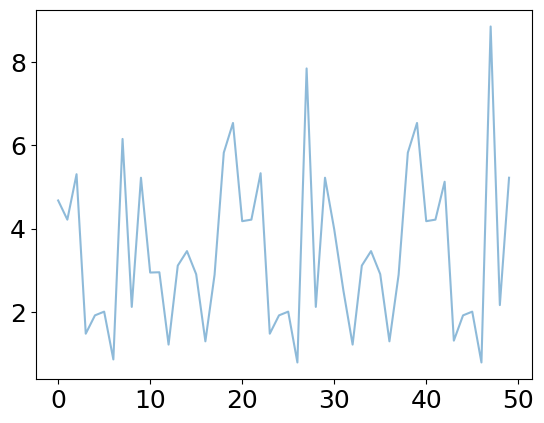

In [ ]:
import h5py
import getdist
from getdist import plots, MCSamples



burnin = 0.02

with h5py.File("emcee_chains/mcmc_results_5k_hmcode_sigma_normal_SN_fog_rebin.h5", "r") as f:
        
    chain = f["chain"][:]  # shape: (nsteps, nwalkers, nparams)
    #chisq = f["chisq"][:]  # shape: (nsteps, nwalkers)
    log_prob = f["log_prob"][:]

    print("log_prob shape:", log_prob.shape)
    print("log_prob:", log_prob)
    #plt.plot(log_prob[4000:4900, 1], alpha=0.5)
    acceptance_fraction = f.attrs["acceptance_fraction"]

    # Get parameter names
    param_names = []
    for i in range(len(f["parameters"].attrs)):
        param_names.append(f["parameters"].attrs[f"param_{i}"])
        


    samples_b4_thin = chain.reshape(-1, chain.shape[2])
        
        
    burnin_end = int(chain.shape[0] * burnin)
        
    chain_after_burnin = chain[burnin_end:, :, :]  # Remove thinning
    samples = chain_after_burnin.reshape(-1, chain.shape[2])  # Flatten to (nsamples, nparams)
    print(samples.shape)
    plt.plot(samples[30:80, 2],   alpha=0.5)


    #samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)





    param_labels = {
        "alpha_omega": r'\Omega_{HI}',
        "alpha_HI": r'b_{HI}',
        "alpha_FoG": r'\sigma_{FoG}',
        "alpha_NL": r'\alpha_{NL}',
        "alpha_PSN": r'\alpha_{PSN}',
        "alpha_int": r'\sigma_{int}',


    }
    print("param_labels:", param_labels)

    ranges = {
        "alpha_omega": [0, 10],
        "alpha_HI": [0, 10],
        "alpha_FoG": [0, 10],
        "alpha_NL": [0, 10],
        "alpha_PSN": [0, 10],
        "alpha_int": [0, 10],
    }
    latex_labels = [param_labels[name] for name in param_names]
        
    mcsamples_sims = MCSamples(samples=samples, 
                        names=param_names,
                        ranges=ranges,
                        labels=latex_labels,
                        settings={
            'ignore_rows':0.00,
            'smooth_scale_2D': 0.3,  
            'fine_bins_2D': 1024,    
            'boundary_correction_order': 0,  
            'mult_bias_correction_order': 0,  
            'smooth_scale_1D': 0.3,   
            'fine_bins': 1024          
     })  






0.6062866266041592 1.4889999999999999 1.93


<Figure size 800x600 with 0 Axes>

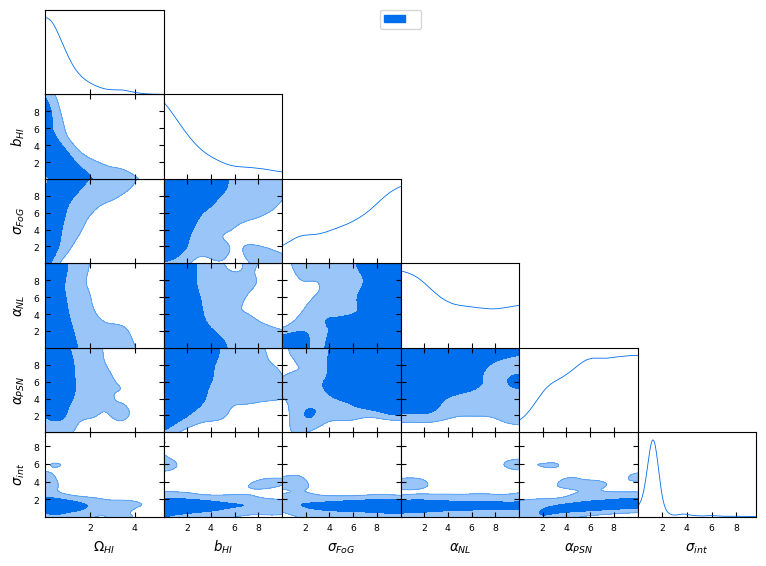

In [44]:
print(omega_HI_fid_mK, bias_HI_fid, sigma_P_HI_fid)
from getdist import plots
g=plots.get_single_plotter(width_inch=8, scaling=True)


g.triangle_plot([mcsamples_sims], filled=True, legend_labels=[' '],)

axes = g.subplots

g.export('plots_may19/mcmc_results_5k_hmcode_sigma_normal_SN_fog_rebin.png', dpi=500)